# Processing Sanson 2018

### Data Filters
1. pdna or etp > mean pdna -3 std
2. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import poola.core as pool

from core import add_transform_col

In [2]:
reads = pd.read_csv('../data/raw/Sanson2018_S2.csv')
tp_genes = ['EEF2']
fp_genes = ['CD81']

In [3]:
clean_reads = (reads.drop(['Context Sequence', 'Gene Symbol'], axis=1)
               .drop_duplicates())
read_cols = ['pDNA', 'A375_RepA', 'A375_RepB']
lognorms = pool.lognorm_columns(reads_df=clean_reads, columns=read_cols)
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['pDNA'], z_low=-3)
print('pDNA Filtered: ' + str(lognorms.shape[0] - filtered_lognorms.shape[0]))

pDNA Filtered: 5


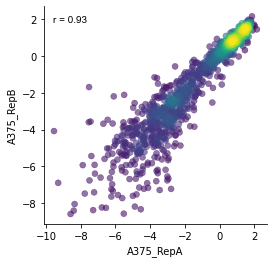

In [4]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='pDNA',
                             target_cols=['A375_RepA', 'A375_RepB'])
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(lfc_df, x='A375_RepA', y = 'A375_RepB')
gpplot.add_correlation(lfc_df, x='A375_RepA', y = 'A375_RepB')
sns.despine()

In [5]:
filtered_lfcs = (lfc_df[lfc_df['Mutation'] == '0'].reset_index(drop=True)
                 .drop(['WTSequence', 'Mutation', 'Mismatch Position'], axis=1))

In [6]:
sg_list = list(filtered_lfcs['Construct Sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [7]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=filtered_lfcs, guide_col='Construct Sequence', condition_indices=[0],
                                                   sep='_')

In [8]:
lfcs_designs = (avg_replicate_lfc_df.rename({'Construct Sequence': 'sgRNA Sequence'}, axis=1)
                .merge(design_df, how = 'inner', on = 'sgRNA Sequence'))
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=tp_genes,
                                fp_genes=fp_genes, gene_col='Target Gene Symbol',
                                score_col='avg_lfc', condition_col='condition')
roc_aucs

,condition,ROC-AUC
0,A375,0.968015


In [9]:
relevant_sgs_designs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(tp_genes)]
filtered_sgs = relevant_sgs_designs[(relevant_sgs_designs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
print('Off target filtered: ' + str(relevant_sgs_designs.shape[0] - filtered_sgs.shape[0]))

Off target filtered: 8


In [10]:
filtered_sgs['neg_lfc'] = -filtered_sgs['avg_lfc']
filtered_sgs = add_transform_col(df=filtered_sgs,
                                 col='neg_lfc',
                                 transform_name='yeo-johnson',
                                 transformed_name='scaled_neg_lfc',
                                 group_col=['Target Gene Symbol'])

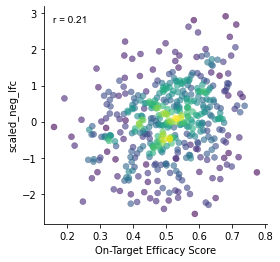

In [11]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=filtered_sgs, y='scaled_neg_lfc', x='On-Target Efficacy Score')
gpplot.add_correlation(data=filtered_sgs, y='scaled_neg_lfc', x='On-Target Efficacy Score')
sns.despine()

In [12]:
training_data = filtered_sgs[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 'Target Cut %',
                              'scaled_neg_lfc']]
training_data

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,scaled_neg_lfc
0,AAAGGTCGGTTCTACGCCTT,CGACAAAGGTCGGTTCTACGCCTTTGGACG,EEF2,47.9,-1.389169
1,AAAGTCTGGTAGAGCTCCTC,CTGGAAAGTCTGGTAGAGCTCCTCGGGCTC,EEF2,20.0,1.126672
3,AACGCTCCTGCTCGTCCTTC,ATGCAACGCTCCTGCTCGTCCTTCCGGGTA,EEF2,7.1,0.643541
4,AACGTCATCATCTCCACCTA,CGTGAACGTCATCATCTCCACCTACGGCGA,EEF2,22.2,-0.337302
7,AAGCAGAGCAAGGACGGTGC,CATCAAGCAGAGCAAGGACGGTGCCGGCTT,EEF2,11.0,0.103722
...,...,...,...,...,...
552,TTGCTGAACTTGCCGTTGGC,TGACTTGCTGAACTTGCCGTTGGCTGGGTC,EEF2,31.3,-1.569158
553,TTGGAAATATACATCATAAG,CATTTTGGAAATATACATCATAAGAGGGCC,EEF2,45.9,-0.591832
555,TTGGGTCTGGCCTCCACGGG,GGCTTTGGGTCTGGCCTCCACGGGTGGGCC,EEF2,25.5,-2.275286
556,TTTCAGGCCCTTGCGCTTGC,CTTCTTTCAGGCCCTTGCGCTTGCGGGTCT,EEF2,97.7,-1.059545


In [13]:
training_data.to_csv('../data/processed/Sanson2018_activity.csv', index=False)